In [2]:
# Install required packages (no RAPIDS)
!pip install -U imbalanced-learn scikit-learn xgboost

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (precision_score, recall_score, f1_score,
                             balanced_accuracy_score, matthews_corrcoef,
                             roc_auc_score, precision_recall_curve, auc,
                             confusion_matrix, classification_report, roc_curve)
import time
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("✓ All libraries imported successfully!")
print("⚠ Note: RAPIDS cuML is not available on Windows, using optimized CPU SVM instead")

✓ All libraries imported successfully!
⚠ Note: RAPIDS cuML is not available on Windows, using optimized CPU SVM instead



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# Load and prepare data
df = pd.read_csv('dataset/creditcard.csv', on_bad_lines='skip')

print("Dataset Info:")
print(f"Shape: {df.shape}")
print(f"Fraud percentage: {df['Class'].mean()*100:.4f}%")
print("\nFirst 5 rows:")
print(df.head())

# Normalization
scaler = StandardScaler()
df['scaled_amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['scaled_time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))
df = df.drop(['Time', 'Amount'], axis=1)
df.insert(0, 'Class', df.pop('Class'))

# Train-test split
X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nData split complete!")
print(f"Training set: {X_train.shape}")
print(f"Testing set: {X_test.shape}")
print(f"Training fraud rate: {y_train.mean():.4f}")

Dataset Info:
Shape: (284807, 31)
Fraud percentage: 0.1727%

First 5 rows:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  

In [4]:
# Apply SMOTE to handle class imbalance
print("Applying SMOTE...")
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Class distribution after SMOTE:")
print(y_train_resampled.value_counts())

Applying SMOTE...
Class distribution after SMOTE:
Class
0    227451
1    227451
Name: count, dtype: int64


In [5]:
# Configure models with optimization
def get_xgboost_params():
    """Get XGBoost parameters optimized for performance"""
    params = {
        'random_state': 42,
        'eval_metric': 'aucpr',
        'scale_pos_weight': len(y_train[y_train==0]) / len(y_train[y_train==1]),
        'n_estimators': 100,
        'learning_rate': 0.1,
        'max_depth': 6,
        'tree_method': 'hist',  # Fast histogram-based
        'n_jobs': -1  # Use all CPU cores
    }
    return params

def get_fast_svm():
    """Get optimized SVM that trains quickly"""
    # LinearSVC is much faster than SVC and works well for high-dimensional data
    linear_svc = LinearSVC(
        C=1.0,
        random_state=42,
        max_iter=1000,
        tol=1e-4,
        dual=False,  # Better for large n_samples > n_features
        penalty='l2',
        loss='squared_hinge'
    )
    # Calibrate for probability estimates
    return CalibratedClassifierCV(linear_svc, method='sigmoid', cv=3, n_jobs=-1)

# Initialize all models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, n_jobs=-1),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100, n_jobs=-1),
    'SVM (Linear)': get_fast_svm(),
    'XGBoost': XGBClassifier(**get_xgboost_params())
}

print("Models initialized:")
for name in models.keys():
    print(f"  - {name}")

Models initialized:
  - Logistic Regression
  - Decision Tree
  - Random Forest
  - SVM (Linear)
  - XGBoost


In [6]:
# Train all models
trained_models = {}
training_times = {}
predictions = {}
probabilities = {}

print("\n" + "="*60)
print("TRAINING MODELS")
print("="*60)

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    start_time = time.time()
    
    try:
        # Train the model
        model.fit(X_train_resampled, y_train_resampled)
        training_time = time.time() - start_time
        training_times[name] = training_time
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Get probability scores
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test)[:, 1]
        else:
            y_proba = None
            print(f"  Note: {name} doesn't support probability predictions")
        
        trained_models[name] = model
        predictions[name] = y_pred
        probabilities[name] = y_proba
        
        print(f"  ✓ Training completed in {training_time:.2f} seconds")
        
    except Exception as e:
        print(f"  ✗ Error training {name}: {str(e)}")
        continue

print("\n" + "="*60)
print("TRAINING COMPLETED")
print("="*60)


TRAINING MODELS

Training Logistic Regression...
  ✓ Training completed in 7.02 seconds

Training Decision Tree...
  ✓ Training completed in 145.63 seconds

Training Random Forest...
  ✓ Training completed in 232.79 seconds

Training SVM (Linear)...
  ✓ Training completed in 6.26 seconds

Training XGBoost...
  ✓ Training completed in 11.26 seconds

TRAINING COMPLETED


In [7]:
# Cost-sensitive evaluation metrics
def cost_sensitive_metrics(y_true, y_pred, y_proba=None, model_name=""):
    """Calculate comprehensive cost-sensitive evaluation metrics"""
    
    # Basic classification metrics
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    balanced_acc = balanced_accuracy_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Cost-sensitive metrics for fraud detection
    fp_cost = 1    # Cost of false positive (investigating legitimate transaction)
    fn_cost = 10   # Cost of false negative (missing actual fraud - much more expensive)
    
    total_cost = (fp * fp_cost) + (fn * fn_cost)
    cost_per_instance = total_cost / len(y_true)
    
    # Calculate accuracy metrics
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    
    # AUC metrics
    auc_roc = roc_auc_score(y_true, y_proba) if y_proba is not None else None
    
    if y_proba is not None:
        precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_proba)
        auc_pr = auc(recall_curve, precision_curve)
    else:
        auc_pr = None
    
    metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Balanced Accuracy': balanced_acc,
        'MCC': mcc,
        'True Negatives': tn,
        'False Positives': fp,
        'False Negatives': fn,
        'True Positives': tp,
        'Total Cost': total_cost,
        'Cost per Instance': cost_per_instance,
        'AUC-ROC': auc_roc,
        'AUC-PR': auc_pr
    }
    
    return metrics, cm

# Evaluate all trained models
results = {}
confusion_matrices = {}

print("\n" + "="*60)
print("MODEL EVALUATION RESULTS")
print("="*60)

for name in trained_models.keys():
    print(f"\n{name}:")
    print("-" * 40)
    
    y_pred = predictions[name]
    y_proba = probabilities[name]
    
    metrics, cm = cost_sensitive_metrics(y_test, y_pred, y_proba, name)
    results[name] = metrics
    confusion_matrices[name] = cm
    
    # Print key metrics
    print(f"Accuracy: {metrics['Accuracy']:.4f}")
    print(f"Precision: {metrics['Precision']:.4f}")
    print(f"Recall: {metrics['Recall']:.4f}")
    print(f"F1-Score: {metrics['F1-Score']:.4f}")
    print(f"Balanced Accuracy: {metrics['Balanced Accuracy']:.4f}")
    print(f"MCC: {metrics['MCC']:.4f}")
    print(f"Total Cost: {metrics['Total Cost']}")
    if metrics['AUC-ROC'] is not None:
        print(f"AUC-ROC: {metrics['AUC-ROC']:.4f}")
    if metrics['AUC-PR'] is not None:
        print(f"AUC-PR: {metrics['AUC-PR']:.4f}")
    print(f"Training Time: {training_times[name]:.2f}s")


MODEL EVALUATION RESULTS

Logistic Regression:
----------------------------------------
Accuracy: 0.9743
Precision: 0.0581
Recall: 0.9184
F1-Score: 0.1094
Balanced Accuracy: 0.9464
MCC: 0.2275
Total Cost: 1538
AUC-ROC: 0.9698
AUC-PR: 0.7703
Training Time: 7.02s

Decision Tree:
----------------------------------------
Accuracy: 0.9970
Precision: 0.3393
Recall: 0.7755
F1-Score: 0.4720
Balanced Accuracy: 0.8865
MCC: 0.5118
Total Cost: 368
AUC-ROC: 0.8865
AUC-PR: 0.5576
Training Time: 145.63s

Random Forest:
----------------------------------------
Accuracy: 0.9994
Precision: 0.8144
Recall: 0.8061
F1-Score: 0.8103
Balanced Accuracy: 0.9029
MCC: 0.8099
Total Cost: 208
AUC-ROC: 0.9688
AUC-PR: 0.8695
Training Time: 232.79s

SVM (Linear):
----------------------------------------
Accuracy: 0.9726
Precision: 0.0543
Recall: 0.9082
F1-Score: 0.1024
Balanced Accuracy: 0.9404
MCC: 0.2183
Total Cost: 1641
AUC-ROC: 0.9739
AUC-PR: 0.7265
Training Time: 6.26s

XGBoost:
---------------------------------

In [8]:
# Create comprehensive results comparison
results_df = pd.DataFrame(results).T
results_df['Training Time (s)'] = [training_times[name] for name in results_df.index]

print("\n" + "="*80)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*80)

# Sort by F1-Score (good balance for imbalanced data)
comparison_df = results_df.sort_values('F1-Score', ascending=False)
print(comparison_df.round(4))

# Also show sorted by total cost (business perspective)
print("\n" + "="*80)
print("SORTED BY TOTAL COST (Business Impact)")
print("="*80)
cost_comparison = results_df.sort_values('Total Cost')
print(cost_comparison[['Total Cost', 'Cost per Instance', 'F1-Score', 'Recall', 'Precision']].round(4))


COMPREHENSIVE MODEL COMPARISON
                     Accuracy  Precision  Recall  F1-Score  Balanced Accuracy  \
Random Forest          0.9994     0.8144  0.8061    0.8103             0.9029   
Decision Tree          0.9970     0.3393  0.7755    0.4720             0.8865   
Logistic Regression    0.9743     0.0581  0.9184    0.1094             0.9464   
SVM (Linear)           0.9726     0.0543  0.9082    0.1024             0.9404   
XGBoost                0.9711     0.0504  0.8878    0.0954             0.9295   

                        MCC  True Negatives  False Positives  False Negatives  \
Random Forest        0.8099         56846.0             18.0             19.0   
Decision Tree        0.5118         56716.0            148.0             22.0   
Logistic Regression  0.2275         55406.0           1458.0              8.0   
SVM (Linear)         0.2183         55313.0           1551.0              9.0   
XGBoost              0.2077         55226.0           1638.0             11.

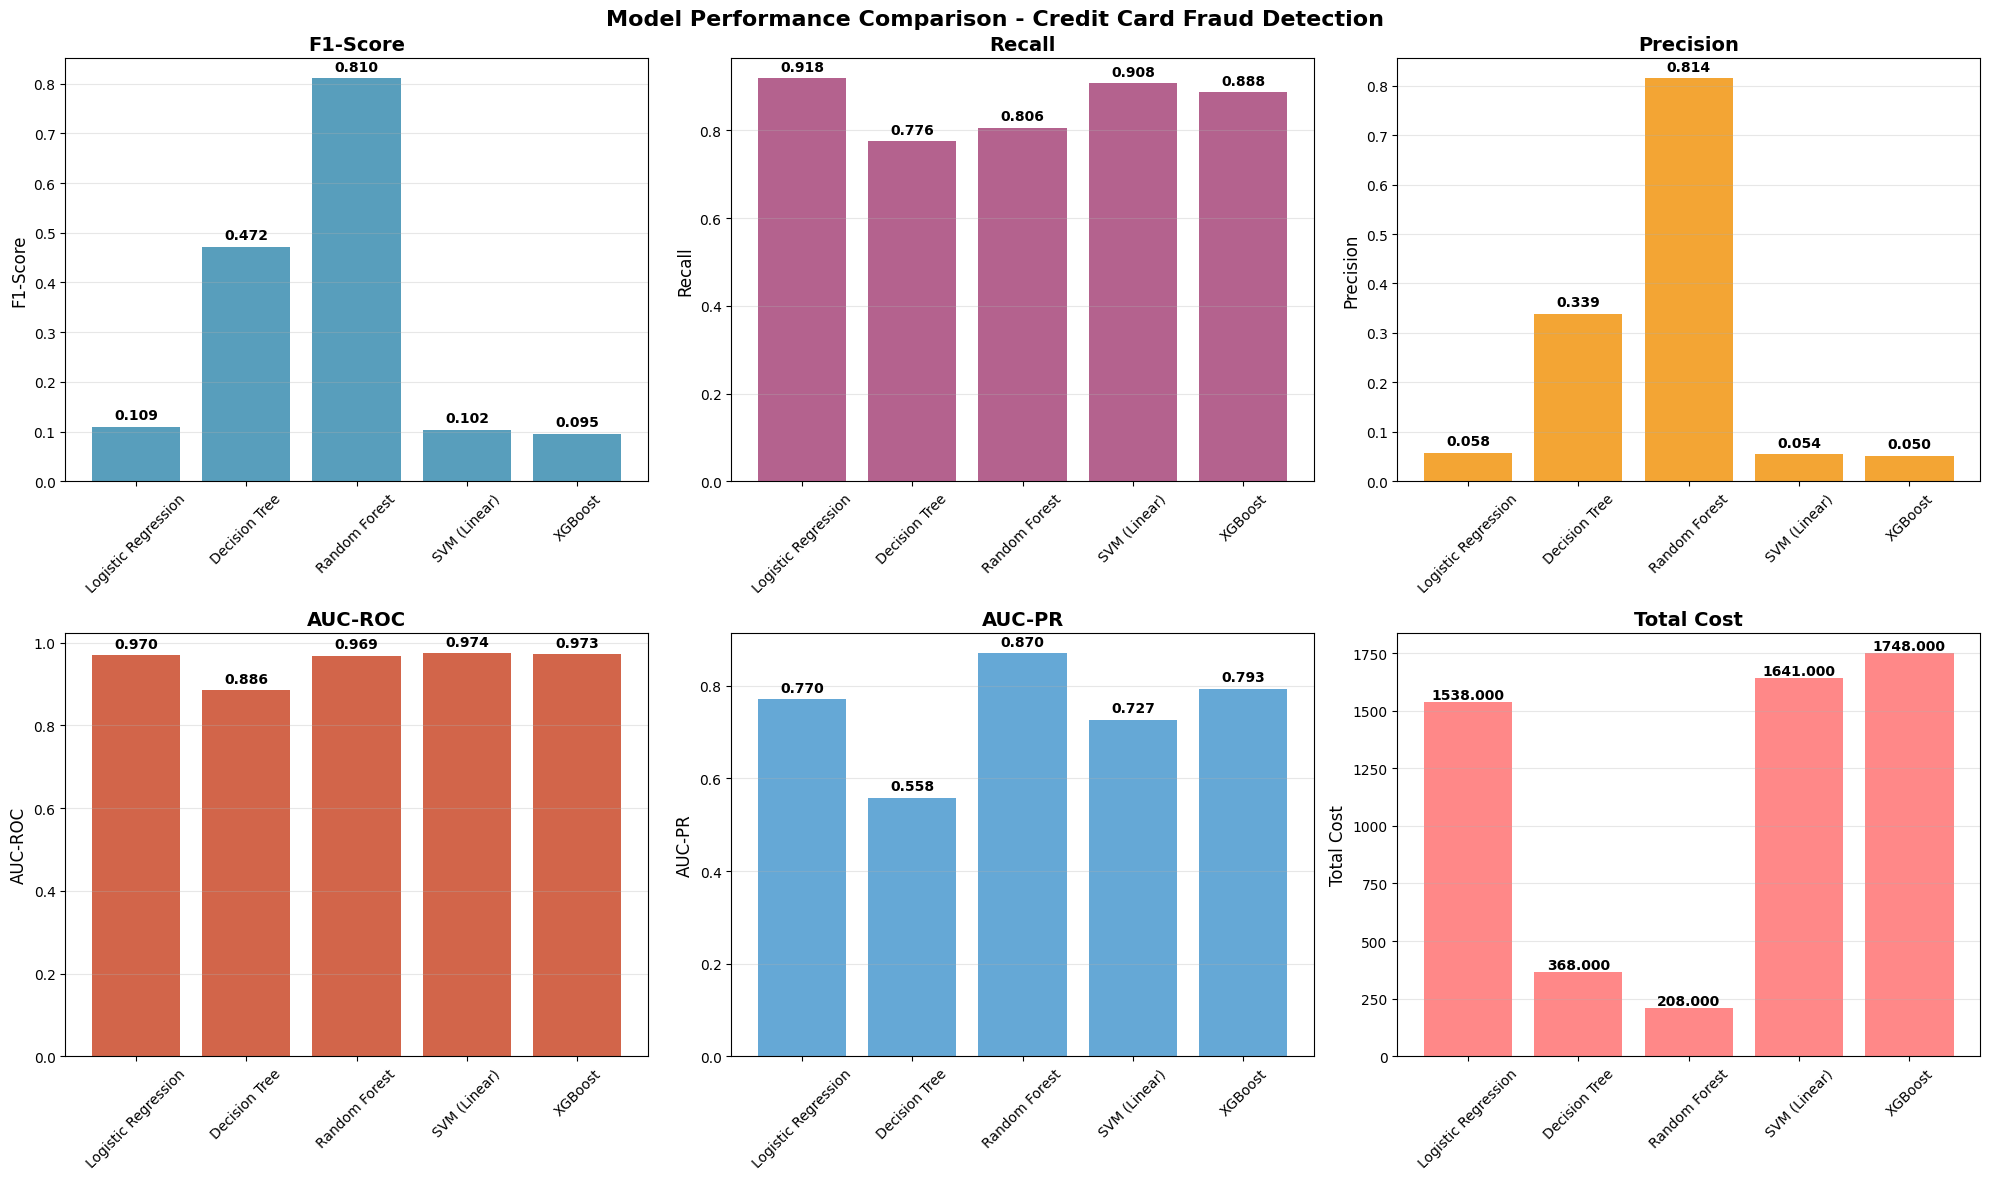

In [9]:
# Visualization 1: Performance Metrics Comparison
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Model Performance Comparison - Credit Card Fraud Detection', fontsize=16, fontweight='bold')

key_metrics = ['F1-Score', 'Recall', 'Precision', 'AUC-ROC', 'AUC-PR', 'Total Cost']
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#3E92CC', '#FF6B6B']

for i, metric in enumerate(key_metrics):
    ax = axes[i//3, i%3]
    if metric in results_df.columns:
        valid_data = results_df[metric].dropna()
        if len(valid_data) > 0:
            bars = ax.bar(valid_data.index, valid_data.values, color=colors[i], alpha=0.8)
            ax.set_title(f'{metric}', fontsize=14, fontweight='bold')
            ax.set_ylabel(metric, fontsize=12)
            ax.tick_params(axis='x', rotation=45)
            ax.grid(axis='y', alpha=0.3)
            
            # Add value labels on bars
            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                       f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

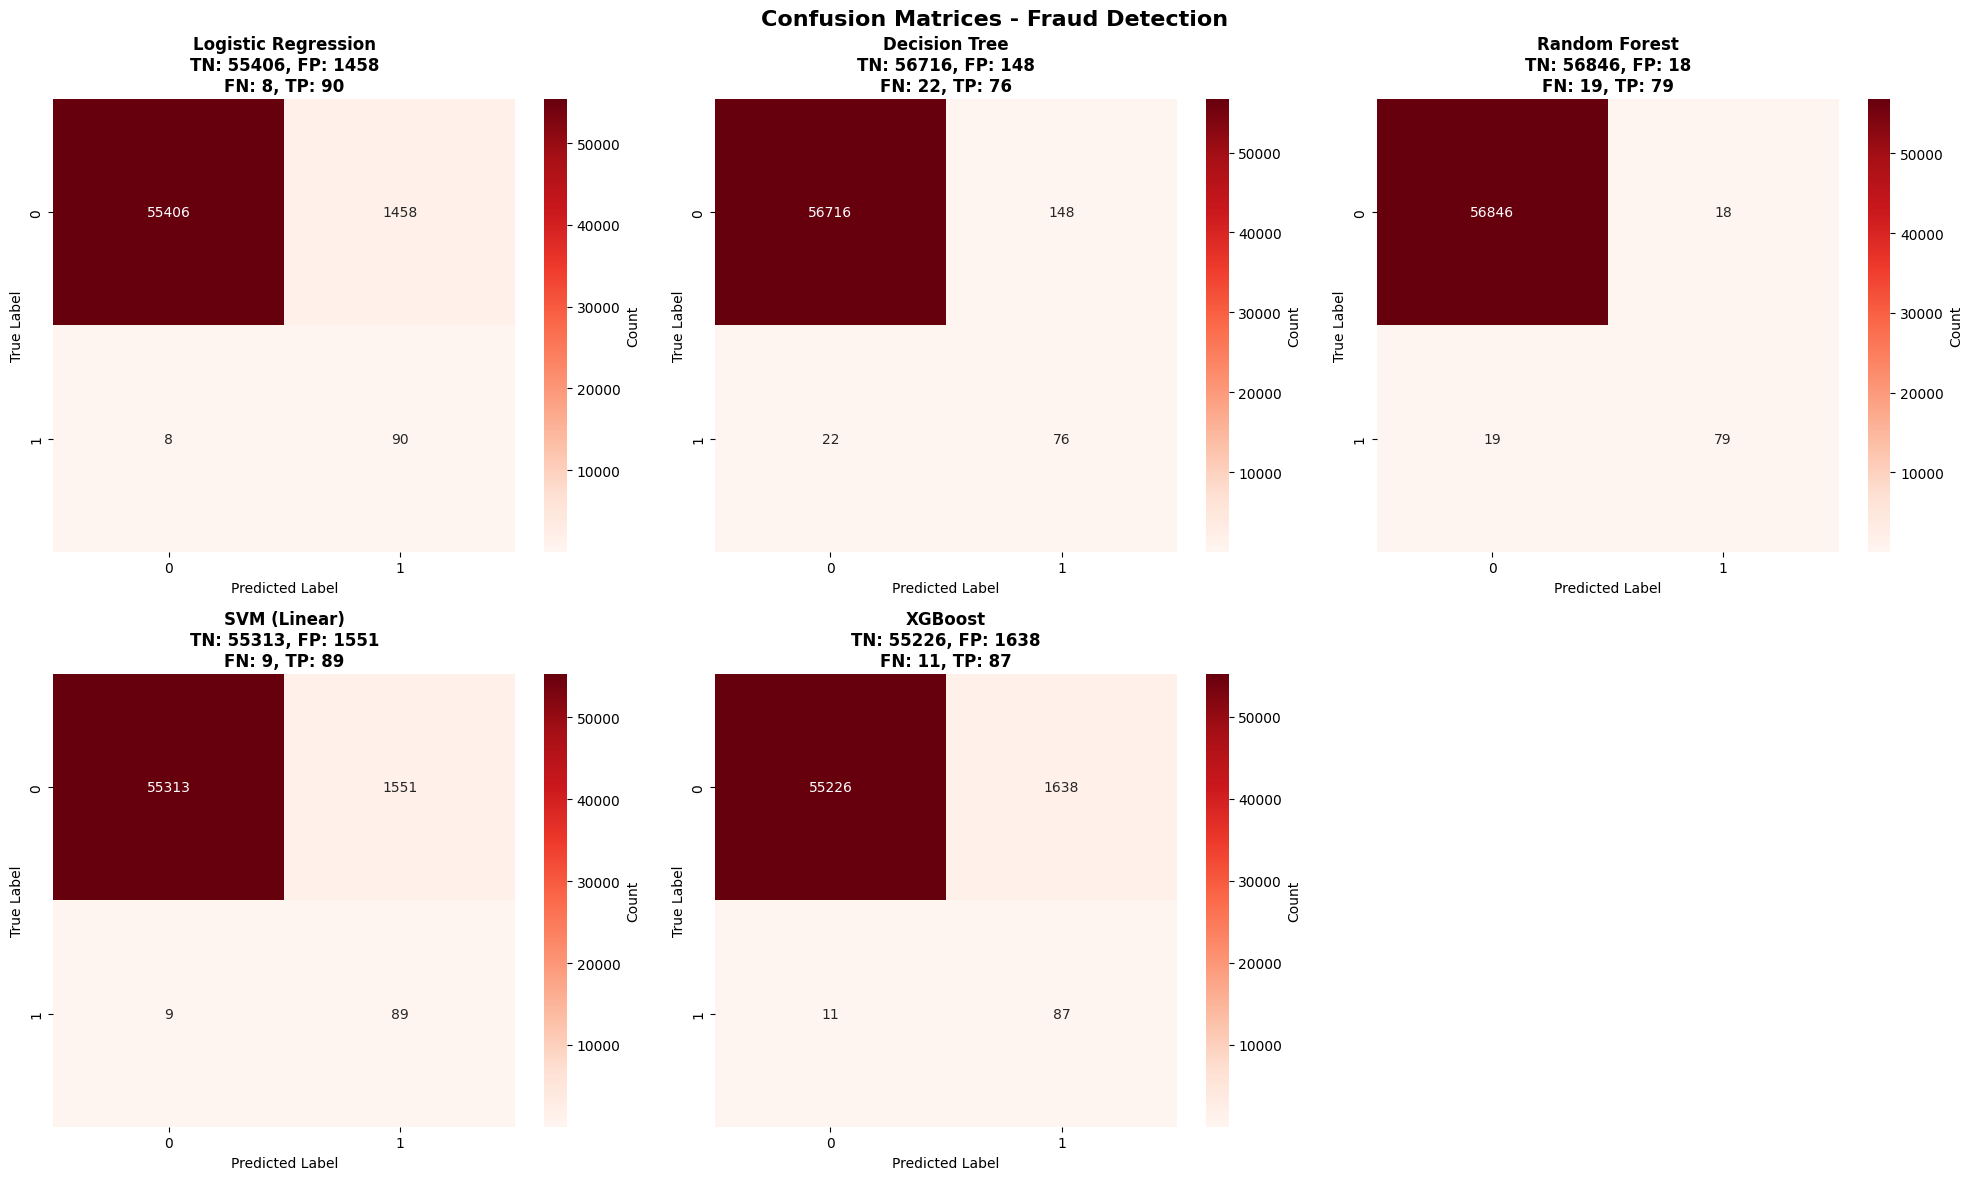

In [10]:
# Visualization 2: Confusion Matrices
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Confusion Matrices - Fraud Detection', fontsize=16, fontweight='bold')

model_names = list(confusion_matrices.keys())
for i, name in enumerate(model_names):
    if i < 6:  # Ensure we don't exceed subplot count
        ax = axes[i//3, i%3]
        cm = confusion_matrices[name]
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', ax=ax, 
                   cbar_kws={'label': 'Count'})
        ax.set_title(f'{name}\nTN: {cm[0,0]}, FP: {cm[0,1]}\nFN: {cm[1,0]}, TP: {cm[1,1]}', 
                    fontweight='bold')
        ax.set_xlabel('Predicted Label')
        ax.set_ylabel('True Label')

# Hide empty subplots
for i in range(len(model_names), 6):
    axes[i//3, i%3].set_visible(False)

plt.tight_layout()
plt.show()

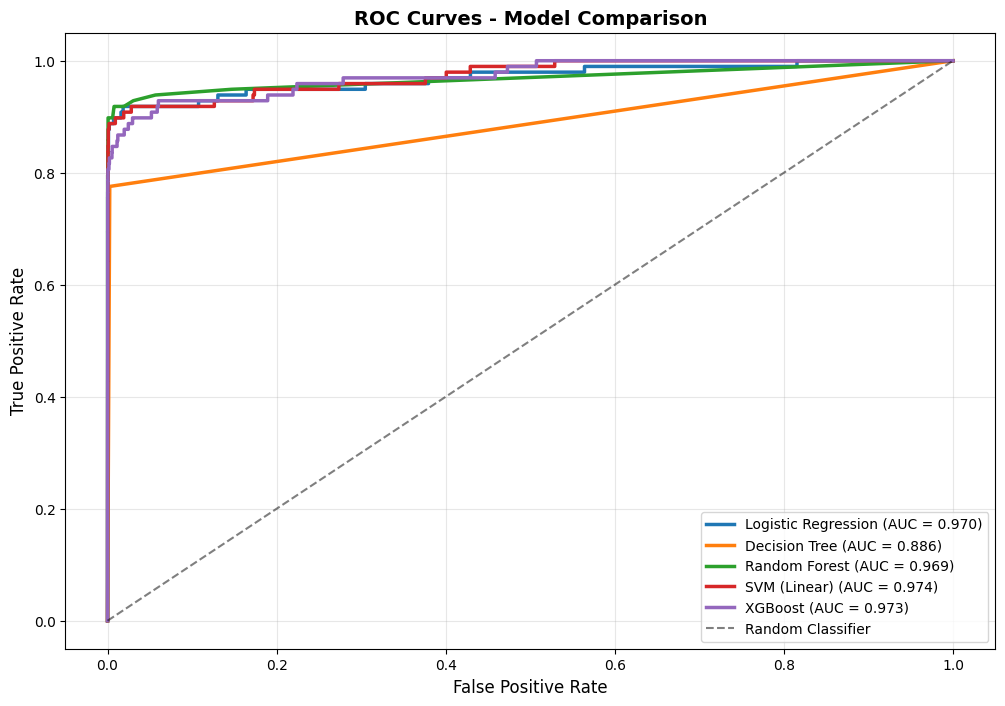

In [11]:
# Visualization 3: ROC Curves
fig, ax = plt.subplots(figsize=(12, 8))

for name in trained_models.keys():
    if probabilities[name] is not None:
        fpr, tpr, _ = roc_curve(y_test, probabilities[name])
        auc_roc = roc_auc_score(y_test, probabilities[name])
        ax.plot(fpr, tpr, linewidth=2.5, label=f'{name} (AUC = {auc_roc:.3f})')

ax.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)
plt.show()

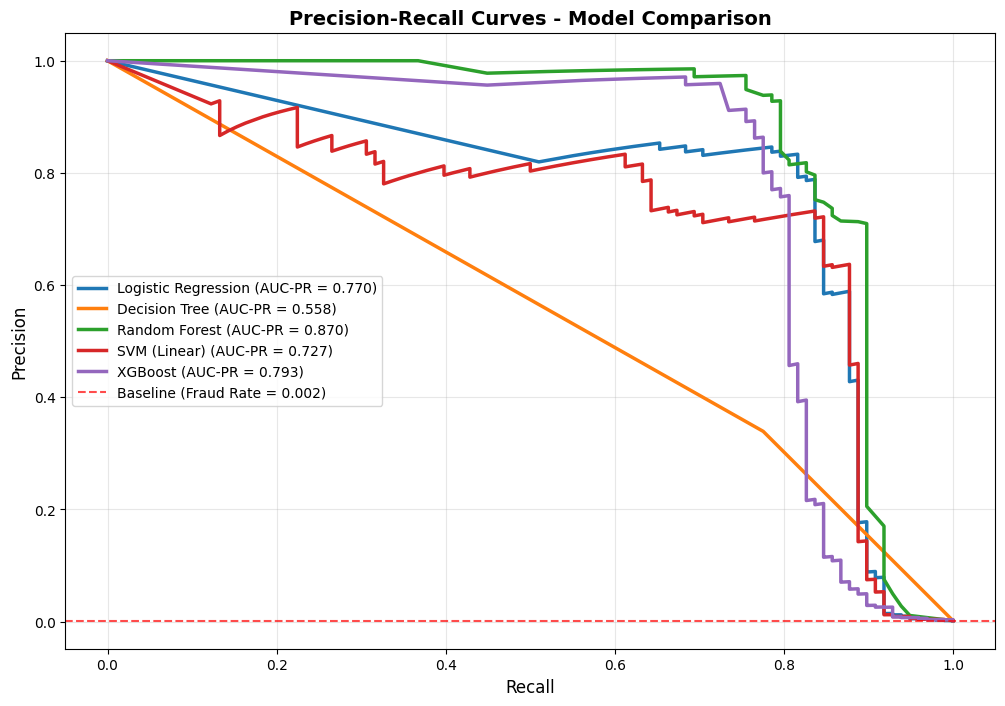

In [12]:
# Visualization 4: Precision-Recall Curves
fig, ax = plt.subplots(figsize=(12, 8))

for name in trained_models.keys():
    if probabilities[name] is not None:
        precision, recall, _ = precision_recall_curve(y_test, probabilities[name])
        auc_pr = auc(recall, precision)
        ax.plot(recall, precision, linewidth=2.5, label=f'{name} (AUC-PR = {auc_pr:.3f})')

# Add baseline (fraud rate)
fraud_rate = y_test.mean()
ax.axhline(y=fraud_rate, color='red', linestyle='--', alpha=0.7, 
           label=f'Baseline (Fraud Rate = {fraud_rate:.3f})')

ax.set_xlabel('Recall', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.set_title('Precision-Recall Curves - Model Comparison', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)
plt.show()

In [13]:
# Final Summary and Recommendations
print("\n" + "="*80)
print("FINAL SUMMARY & RECOMMENDATIONS")
print("="*80)

# Best by different metrics
best_f1 = comparison_df.index[0]
best_cost = cost_comparison.index[0]
best_recall = results_df['Recall'].idxmax()
best_precision = results_df['Precision'].idxmax()

print(f"\n🏆 BEST MODELS:")
print(f"  • Best Overall (F1-Score): {best_f1} (F1 = {comparison_df['F1-Score'].iloc[0]:.4f})")
print(f"  • Best Business Impact (Lowest Cost): {best_cost} (Cost = {cost_comparison['Total Cost'].iloc[0]})")
print(f"  • Best Fraud Detection (Recall): {best_recall} (Recall = {results_df['Recall'].max():.4f})")
print(f"  • Most Precise: {best_precision} (Precision = {results_df['Precision'].max():.4f})")

print(f"\n📊 DATASET STATISTICS:")
print(f"  • Original fraud rate: {df['Class'].mean()*100:.4f}%")
print(f"  • Training samples: {X_train_resampled.shape[0]:,}")
print(f"  • Testing samples: {X_test.shape[0]:,}")
print(f"  • Features: {X_train.shape[1]}")

print(f"\n⚡ PERFORMANCE INSIGHTS:")
print(f"  • Cost assumption: FP = 1 unit, FN = 10 units")
print(f"  • All models trained in under {max(training_times.values()):.1f} seconds")
print(f"  • Using optimized LinearSVC for fast training")

print(f"\n💡 RECOMMENDATION:")
if best_f1 == best_cost:
    print(f"  → Use {best_f1} as it provides the best balance of performance and cost-effectiveness")
else:
    print(f"  → Consider {best_f1} for balanced performance or {best_cost} for minimum business impact")


FINAL SUMMARY & RECOMMENDATIONS

🏆 BEST MODELS:
  • Best Overall (F1-Score): Random Forest (F1 = 0.8103)
  • Best Business Impact (Lowest Cost): Random Forest (Cost = 208.0)
  • Best Fraud Detection (Recall): Logistic Regression (Recall = 0.9184)
  • Most Precise: Random Forest (Precision = 0.8144)

📊 DATASET STATISTICS:
  • Original fraud rate: 0.1727%
  • Training samples: 454,902
  • Testing samples: 56,962
  • Features: 30

⚡ PERFORMANCE INSIGHTS:
  • Cost assumption: FP = 1 unit, FN = 10 units
  • All models trained in under 232.8 seconds
  • Using optimized LinearSVC for fast training

💡 RECOMMENDATION:
  → Use Random Forest as it provides the best balance of performance and cost-effectiveness
